In [ ]:
# !git clone "https://github.com/Marshmallow0603/water_marks"
# !mv water_marks/main/* ./

In [9]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import os

from model.network import Generator

In [10]:
PATH_IMAGE = 'input/1.png'
OUTPUT_NAME = 'output/1.png'
NAME_MASK = 'avito1'

In [11]:
use_cuda_if_available = False
device = torch.device('cuda' if torch.cuda.is_available() 
                             and use_cuda_if_available else 'cpu')

sd_path = 'weights\save_weights.pth'

generator = Generator(checkpoint=sd_path, return_flow=True).to(device)

In [12]:

def find_mask_in_list(substring:str, string_list:list[str]) -> str:
    for string in string_list:
        if substring in string:
            return string
    raise ValueError ("Нет такой маски")


def mask_watermark(name:str, size:tuple[int]) -> None:
    directory = 'masks'
    files = os.listdir(directory)
    name_file = find_mask_in_list(name, files)
    
    if 'avito1' in name_file:
        mask = Image.open(directory + '/' + name_file)
        mask_pil = Image.new('RGB', size, 'black')
        mask_pil.paste(mask, (mask_pil.size[0]-mask.size[0], mask_pil.size[1]-mask.size[1]))
    return mask_pil

image_pil = Image.open(PATH_IMAGE)
mask_pil = mask_watermark(name=NAME_MASK, size=image_pil.size)

In [13]:
image = T.ToTensor()(image_pil).to(device)
mask = T.ToTensor()(mask_pil).to(device)

# output = generator.infer(image, mask)

In [14]:
import torch.autograd.profiler as profiler

with profiler.profile() as prof:
    output = generator.infer(image, mask)
    
print(prof.key_averages().table())

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::alias         0.00%      18.000us         0.00%      18.000us      18.000us             1  
              aten::unsqueeze         0.00%      12.000us         0.00%      18.000us       9.000us             2  
             aten::as_strided         0.01%     956.000us         0.01%     956.000us       3.074us           311  
                  aten::slice         0.01%       1.173ms         0.02%       2.040ms       7.312us           279  
                    aten::mul         2.76%     308.972ms         2.76%     309.081ms       6.308ms            49  
                     aten::to         0.00%     124.000us         0.02% 

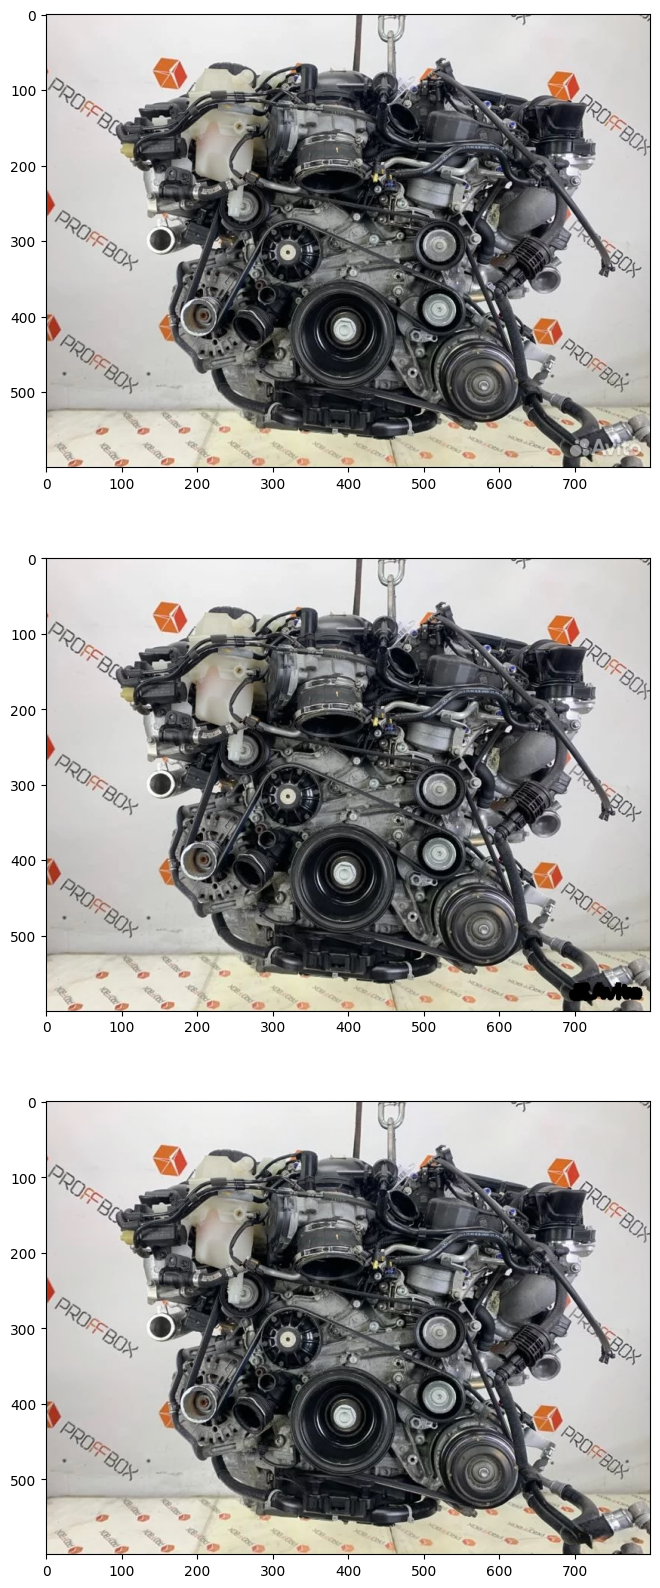

In [15]:
mask = (mask[0:1] > 0.).to(dtype=torch.float32)
image_masked = (image*(1-mask)).permute(1, 2, 0).cpu()

w, h = image_pil.size

_, axes = plt.subplots(nrows=3, figsize=(20, 20))
axes[0].imshow(image_pil)
axes[1].imshow(image_masked)
axes[2].imshow(output)
plt.show()

In [16]:
image = Image.fromarray(output)
image.save(OUTPUT_NAME)